In [1]:
from tensorflow.keras.callbacks import EarlyStopping
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , Adamax+


from tensorflow.keras import regularizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image as keras_image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')




# Use the uploaded file
# data = 'C:/Users/91738/OneDrive/Desktop/Nail Disease Detection/data/train'


data = "/content/drive/MyDrive/MajorProject/data/train"

class_folds = os.listdir(data)
def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)

    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)

        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)

            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
df = create_dataframe(data)

Mounted at /content/drive


In [3]:
df.sample(10)

,Filepaths,Labels
789,/content/drive/MyDrive/MajorProject/data/train...,clubbing
563,/content/drive/MyDrive/MajorProject/data/train...,Onychogryphosis
3204,/content/drive/MyDrive/MajorProject/data/train...,Acral_Lentiginous_Melanoma
1161,/content/drive/MyDrive/MajorProject/data/train...,clubbing
520,/content/drive/MyDrive/MajorProject/data/train...,Onychogryphosis
46,/content/drive/MyDrive/MajorProject/data/train...,Onychogryphosis
1300,/content/drive/MyDrive/MajorProject/data/train...,clubbing
999,/content/drive/MyDrive/MajorProject/data/train...,clubbing
588,/content/drive/MyDrive/MajorProject/data/train...,Onychogryphosis
3272,/content/drive/MyDrive/MajorProject/data/train...,Acral_Lentiginous_Melanoma


In [4]:
print("The Classes:",np.unique(df['Labels']))

The Classes: ['Acral_Lentiginous_Melanoma' 'Healthy_Nail' 'Onychogryphosis'
 'blue_finger' 'clubbing' 'pitting']


In [5]:
class_counts = df['Labels'].value_counts()
class_counts

,count
Labels,
clubbing,767
Acral_Lentiginous_Melanoma,735
Onychogryphosis,677
pitting,639
blue_finger,603
Healthy_Nail,572


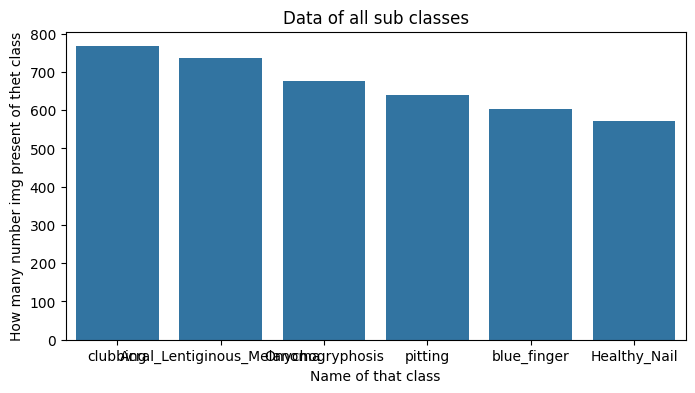

In [6]:
plt.figure(figsize=(8,4))
ax = sns.barplot(x = class_counts.index, y= class_counts.values, orient='v')
plt.xlabel("Name of that class")
plt.ylabel("How many number img present of thet class")
plt.title("Data of all sub classes")
plt.show()

In [7]:
train_df,test_df = train_test_split(df,test_size=0.2,random_state=42)

In [8]:
df.shape

(3993, 2)

In [9]:
train_df.shape,test_df.shape

((3194, 2), (799, 2))

In [10]:
train_df,validation_df =  train_test_split(train_df,test_size=0.2,random_state=42)

In [11]:
train_df.shape,validation_df.shape

((2555, 2), (639, 2))

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepaths',
    y_col = 'Labels',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False,
    seed=42
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col = 'Filepaths',
    y_col = 'Labels',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False,
    seed=42
)

test_generator = train_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepaths',
    y_col = 'Labels',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False,
    seed=42
)

Found 2555 validated image filenames belonging to 6 classes.
Found 639 validated image filenames belonging to 6 classes.
Found 799 validated image filenames belonging to 6 classes.


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping

# Load the Xception base model without the top layer
base_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

# Define the new model with updated architecture
model = Sequential([
    base_model,  # Pretrained model
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Added L2 regularization
    BatchNormalization(),  # Batch normalization moved here
    Dropout(0.3),  # Reduced dropout rate for better regularization
    Dense(6, activation='softmax', kernel_regularizer=l2(0.01))  # Output layer with L2
])

# Compile the model with a lower learning rate
model.compile(
    optimizer=Adamax(learning_rate=0.0005),  # Reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Improved early stopping to restore the best model weights
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True  # Restore the best weights instead of the final ones
)

# Train the model
history = model.fit(
    train_generator,  # Training data generator
    validation_data=valid_generator,  # Validation data generator
    epochs=50,
    verbose=1,
    validation_steps=None,
    shuffle=False,
    callbacks=[callback]
)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 2514s 31s/step - accuracy: 0.6104 - loss: 5.6975 - val_accuracy: 0.8326 - val_loss: 5.3842
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 76s 956ms/step - accuracy: 0.8941 - loss: 4.5589 - val_accuracy: 0.9077 - val_loss: 4.7038
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 71s 884ms/step - accuracy: 0.9492 - loss: 4.1063 - val_accuracy: 0.9296 - val_loss: 4.1327
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 830ms/step - accuracy: 0.9524 - loss: 3.8100 - val_accuracy: 0.9624 - val_loss: 3.6668
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 68s 852ms/step - accuracy: 0.9782 - loss: 3.4671 - val_accuracy: 0.9421 - val_loss: 3.3742
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 77s 961ms/step - accuracy: 0.9822 - loss: 3.1844 - val_accuracy: 0.9515 - val_loss: 3.0826
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 77s 965ms/step - accuracy: 0.9832 - loss: 2.9225 - val_accuracy: 0.9499 - val_loss: 2.8513
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 873ms/step - accuracy: 0.9889 - loss: 2.6718 - val_accuracy: 0.946

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,055,692 (244.35 MB)

 Trainable params: 21,333,550 (81.38 MB)

 Non-trainable params: 55,040 (215.00 KB)

 Optimizer params: 42,667,102 (162.76 MB)

In [15]:
test_loss_exception, test_accuracy_exception = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy_exception)

25/25 ━━━━━━━━━━━━━━━━━━━━ 560s 23s/step - accuracy: 0.9551 - loss: 0.1944
Test Accuracy: 0.9561952352523804


In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

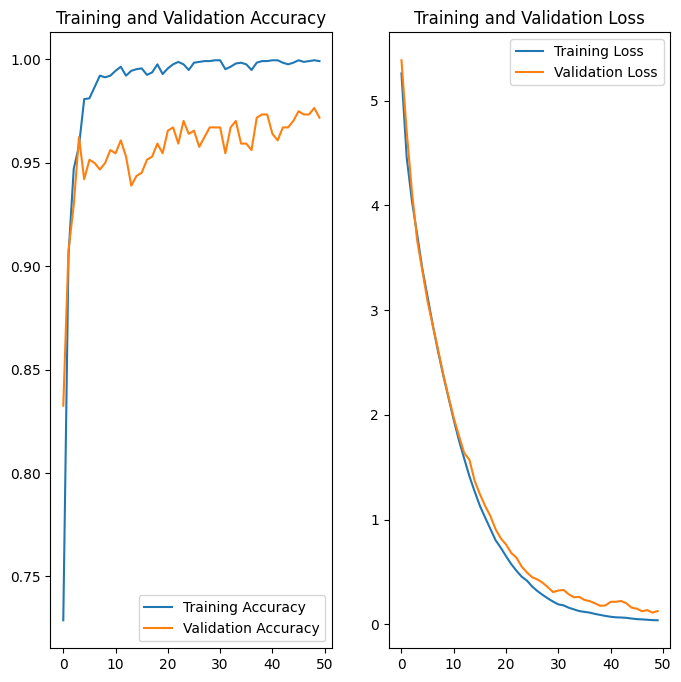

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
import numpy as np

# Obtain true labels (y_true) from the test generator
y_true = test_generator.classes  # This will give you the true labels as integers
class_indices = test_generator.class_indices  # To get the mapping of class indices to labels
class_labels = list(class_indices.keys())  # Get class labels as a list

# Predict the labels for the test data
y_pred_prob = model.predict(test_generator)  # This gives probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions


25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 567ms/step


Classification Report:
                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       0.92      0.99      0.96       124
              Healthy_Nail       0.99      0.98      0.99       112
           Onychogryphosis       0.99      0.95      0.97       148
               blue_finger       0.94      0.92      0.93       121
                  clubbing       0.97      0.94      0.96       159
                   pitting       0.95      0.99      0.97       135

                  accuracy                           0.96       799
                 macro avg       0.96      0.96      0.96       799
              weighted avg       0.96      0.96      0.96       799



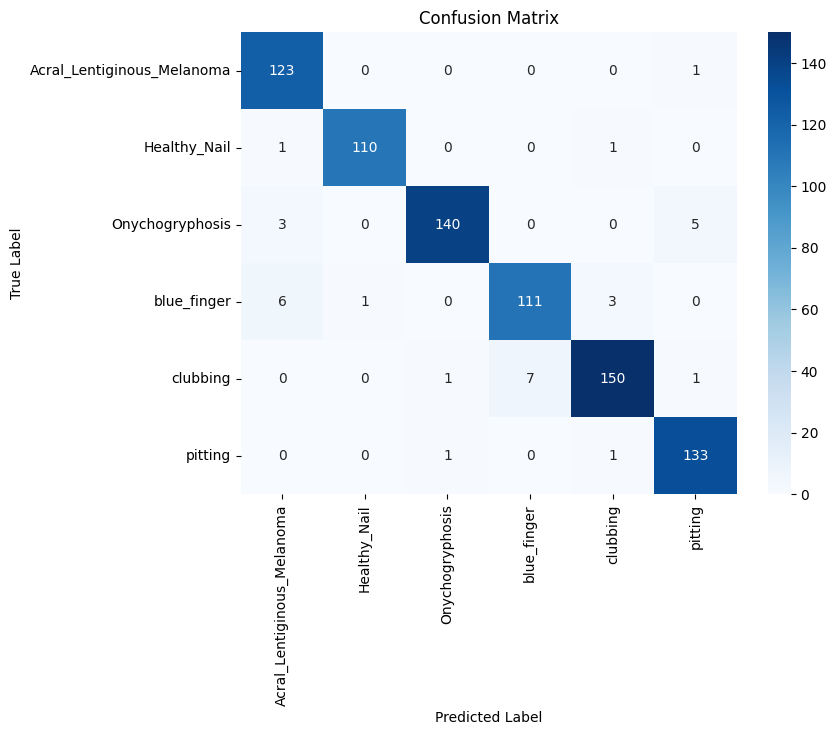

In [25]:
# ['Acral_Lentiginous_Melanoma' 'Healthy_Nail' 'Onychogryphosis'
#  'blue_finger' 'clubbing' 'pitting']

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Replace y_true and y_pred with your actual labels and predictions
# y_true = ... # Actual labels for test data
# y_pred = ... # Predicted labels from your model

# 1. Classification report to get accuracy for each class
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis',
 'blue_finger', 'clubbing', 'pitting']))

# 2. Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis',
 'blue_finger', 'clubbing', 'pitting'],
            yticklabels=['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis',
 'blue_finger', 'clubbing', 'pitting'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Classification Report:
                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       0.92      0.99      0.96       124
              Healthy_Nail       0.99      0.98      0.99       112
           Onychogryphosis       0.99      0.95      0.97       148
               blue_finger       0.94      0.92      0.93       121
                  clubbing       0.97      0.94      0.96       159
                   pitting       0.95      0.99      0.97       135

                  accuracy                           0.96       799
                 macro avg       0.96      0.96      0.96       799
              weighted avg       0.96      0.96      0.96       799

Class-wise Accuracy:
Acral_Lentiginous_Melanoma: 99.19%
Healthy_Nail: 98.21%
Onychogryphosis: 94.59%
blue_finger: 91.74%
clubbing: 94.34%
pitting: 98.52%


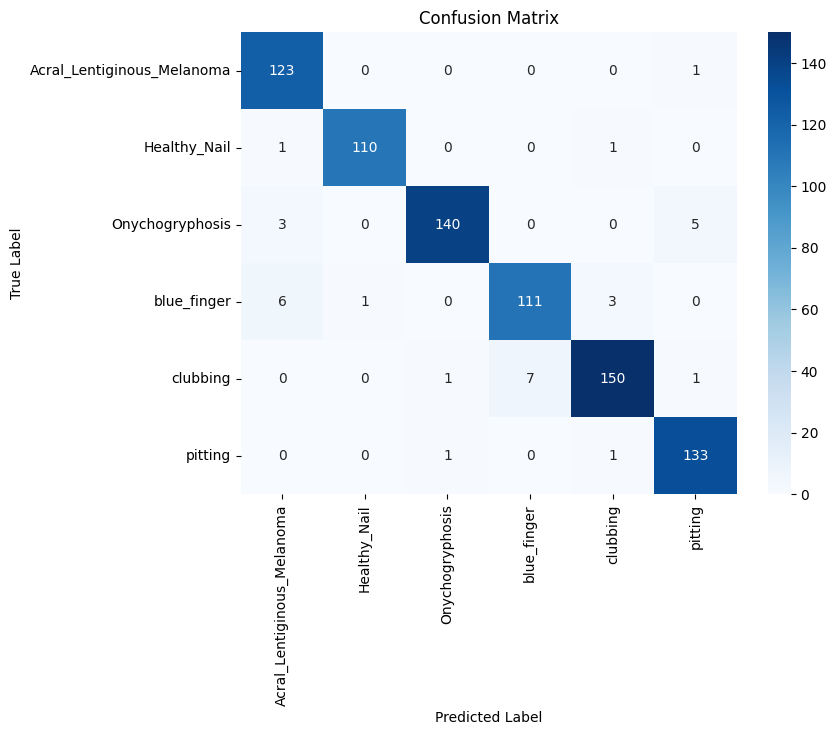

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Replace y_true and y_pred with your actual labels and predictions
# y_true = ... # Actual labels for test data
# y_true = np.array([...])  # Add actual class labels here
# y_pred = np.array([...])  # Add predicted class labels here

class_labels = ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis',
                'blue_finger', 'clubbing', 'pitting']

# 1. Classification report to get accuracy for each class
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 2. Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# 3. Class-wise accuracy calculation
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print("Class-wise Accuracy:")
for label, accuracy in zip(class_labels, class_accuracy):
    print(f"{label}: {accuracy * 100:.2f}%")

# 4. Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


ROC AUC Scores:
Acral_Lentiginous_Melanoma: 0.999
Healthy_Nail: 1.000
Onychogryphosis: 0.998
blue_finger: 0.996
clubbing: 0.995
pitting: 0.999


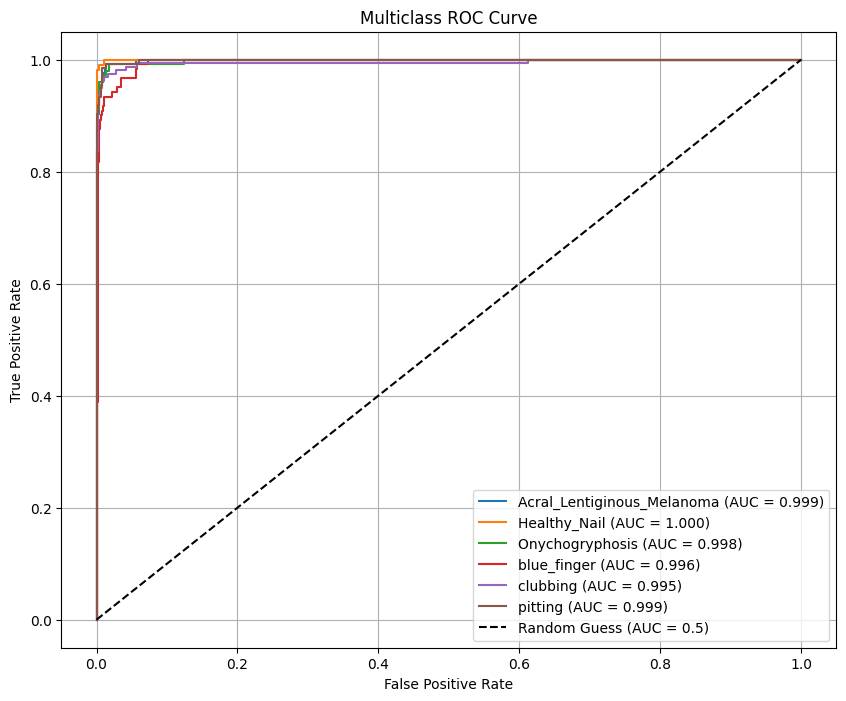

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Replace y_true and y_pred with your actual labels and predictions
# Replace y_proba with your predicted probabilities for each class
# y_true = ... # Actual labels for test data
# y_proba = ... # Predicted probabilities from your model

# Classes
classes = ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis',
           'blue_finger', 'clubbing', 'pitting']

# Binarize the output labels for multiclass ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(classes)))

# 1. Calculate ROC AUC for each class
roc_auc = {}
for i, class_name in enumerate(classes):
    roc_auc[class_name] = roc_auc_score(y_true_bin[:, i], y_pred_prob[:, i])

# Print ROC AUC scores
print("ROC AUC Scores:")
for class_name, score in roc_auc.items():
    print(f"{class_name}: {score:.3f}")

# 2. Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc[class_name]:.3f})")

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")

# Customize the plot
plt.title("Multiclass ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping

# Load the Xception base model without the top layer
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

# Define the new model with updated architecture
model = Sequential([
    base_model,  # Pretrained model
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Added L2 regularization
    BatchNormalization(),  # Batch normalization moved here
    Dropout(0.3),  # Reduced dropout rate for better regularization
    Dense(6, activation='softmax', kernel_regularizer=l2(0.01))  # Output layer with L2
])

# Compile the model with a lower learning rate
model.compile(
    optimizer=Adamax(learning_rate=0.0005),  # Reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Improved early stopping to restore the best model weights
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True  # Restore the best weights instead of the final ones
)

# Train the model
history = model.fit(
    train_generator,  # Training data generator
    validation_data=valid_generator,  # Validation data generator
    epochs=50,
    verbose=1,
    validation_steps=None,
    shuffle=False,
    callbacks=[callback]
)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.5943 - loss: 5.9002 - val_accuracy: 0.7418 - val_loss: 5.0575
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 73s 911ms/step - accuracy: 0.8632 - loss: 4.7083 - val_accuracy: 0.8654 - val_loss: 4.5109
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 771ms/step - accuracy: 0.9067 - loss: 4.3409 - val_accuracy: 0.8998 - val_loss: 4.1749
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 61s 762ms/step - accuracy: 0.9438 - loss: 4.0047 - val_accuracy: 0.9139 - val_loss: 3.9403
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 811ms/step - accuracy: 0.9590 - loss: 3.7190 - val_accuracy: 0.9155 - val_loss: 3.7141
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 78s 759ms/step - accuracy: 0.9630 - loss: 3.4975 - val_accuracy: 0.9202 - val_loss: 3.4317
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 791ms/step - accuracy: 0.9736 - loss: 3.2254 - val_accuracy: 0.9327 - val_loss: 3.2154
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 61s 764ms/

In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,919,796 (255.28 MB)

 Trainable params: 22,294,950 (85.05 MB)

 Non-trainable params: 34,944 (136.50 KB)

 Optimizer params: 44,589,902 (170.10 MB)

In [30]:
test_loss_InceptionV3, test_accuracy_InceptionV3 = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy_InceptionV3)

25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 563ms/step - accuracy: 0.9614 - loss: 0.2064
Test Accuracy: 0.9624530673027039


In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

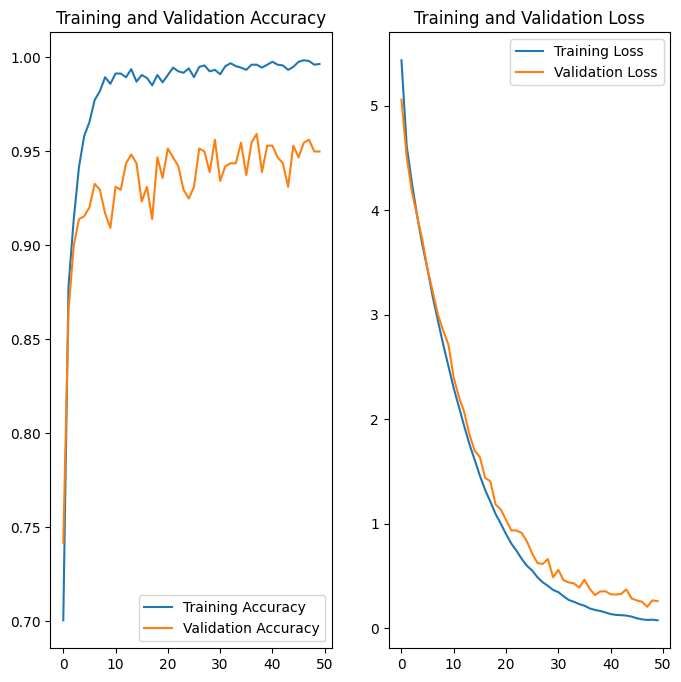

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
import numpy as np

# Obtain true labels (y_true) from the test generator
y_true = test_generator.classes  # This will give you the true labels as integers
class_indices = test_generator.class_indices  # To get the mapping of class indices to labels
class_labels = list(class_indices.keys())  # Get class labels as a list

# Predict the labels for the test data
y_pred_prob = model.predict(test_generator)  # This gives probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 809ms/step


Classification Report:
                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       0.97      0.97      0.97       124
              Healthy_Nail       1.00      0.98      0.99       112
           Onychogryphosis       0.99      0.97      0.98       148
               blue_finger       0.99      0.91      0.95       121
                  clubbing       0.90      0.98      0.94       159
                   pitting       0.97      0.98      0.97       135

                  accuracy                           0.96       799
                 macro avg       0.97      0.96      0.97       799
              weighted avg       0.97      0.96      0.97       799

Class-wise Accuracy:
Acral_Lentiginous_Melanoma: 96.77%
Healthy_Nail: 98.21%
Onychogryphosis: 96.62%
blue_finger: 90.91%
clubbing: 98.11%
pitting: 97.78%


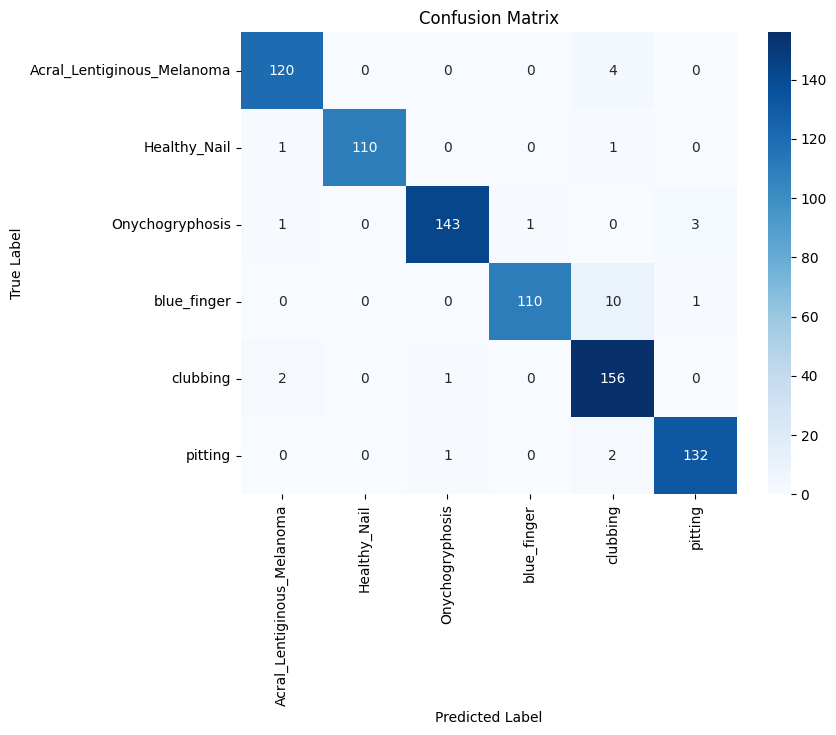

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Replace y_true and y_pred with your actual labels and predictions
# y_true = ... # Actual labels for test data
# y_true = np.array([...])  # Add actual class labels here
# y_pred = np.array([...])  # Add predicted class labels here

class_labels = ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis',
                'blue_finger', 'clubbing', 'pitting']

# 1. Classification report to get accuracy for each class
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 2. Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# 3. Class-wise accuracy calculation
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print("Class-wise Accuracy:")
for label, accuracy in zip(class_labels, class_accuracy):
    print(f"{label}: {accuracy * 100:.2f}%")

# 4. Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


ROC AUC Scores:
Acral_Lentiginous_Melanoma: 0.999
Healthy_Nail: 1.000
Onychogryphosis: 0.999
blue_finger: 0.997
clubbing: 0.998
pitting: 0.999


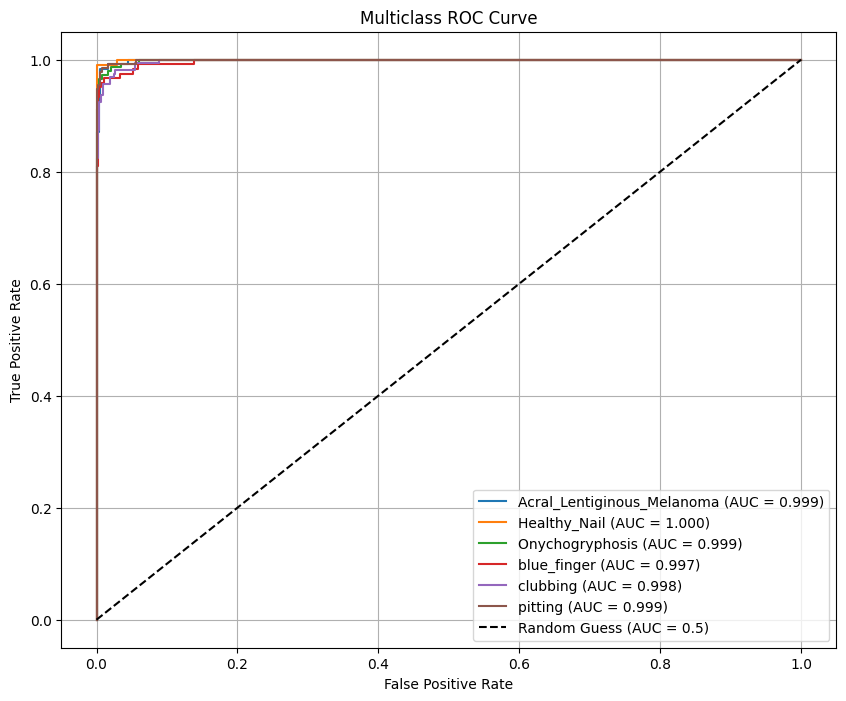

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Replace y_true and y_pred with your actual labels and predictions
# Replace y_proba with your predicted probabilities for each class
# y_true = ... # Actual labels for test data
# y_proba = ... # Predicted probabilities from your model

# Classes
classes = ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis',
           'blue_finger', 'clubbing', 'pitting']

# Binarize the output labels for multiclass ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(classes)))

# 1. Calculate ROC AUC for each class
roc_auc = {}
for i, class_name in enumerate(classes):
    roc_auc[class_name] = roc_auc_score(y_true_bin[:, i], y_pred_prob[:, i])

# Print ROC AUC scores
print("ROC AUC Scores:")
for class_name, score in roc_auc.items():
    print(f"{class_name}: {score:.3f}")

# 2. Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc[class_name]:.3f})")

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")

# Customize the plot
plt.title("Multiclass ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


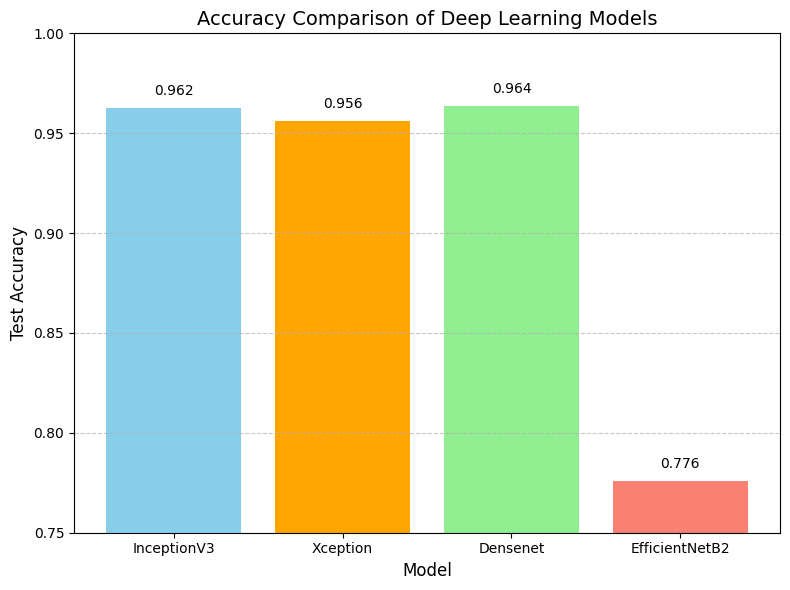

In [1]:
import matplotlib.pyplot as plt

# Model names and their respective accuracies
models = ['InceptionV3', 'Xception', 'Densenet', 'EfficientNetB2']
accuracies = [0.96245, 0.95619, 0.96370, 0.77603]
colors = ['skyblue', 'orange', 'lightgreen', 'salmon']

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=colors)

# Annotate each bar with accuracy value
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

# Chart title and axis labels
plt.title('Accuracy Comparison of Deep Learning Models', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(0.75, 1.0)

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
